# Group Number: 32

# Student 1: Ryan Meghoe

# Student 2: Nikita Jain

# Student 3: Andrei Rykov

# Downloading Data and Preliminaries


In [5]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [6]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [7]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [8]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [9]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [10]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

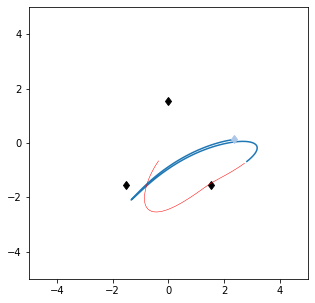

Charges are [-0.16157069 -0.9385916  -0.53660326]


In [11]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

## Data Handling and Preprocessing

In [12]:
import torch.nn.functional as f
import torch

simulation_train = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 110 - x.shape[0], 0)).unsqueeze(0), simulation_train)))
simulation_valid = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 110 - x.shape[0], 0)).unsqueeze(0), simulation_valid)))
simulation_test = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 110 - x.shape[0], 0)).unsqueeze(0), simulation_test)))


simulation_continued_train = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 0, 60 - x.shape[0])).unsqueeze(0), simulation_continued_train)))
simulation_continued_valid = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 0, 60 - x.shape[0])).unsqueeze(0), simulation_continued_valid)))
simulation_continued_test = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 0, 60 - x.shape[0])).unsqueeze(0), simulation_continued_test)))


charges_train = torch.cat(list(map(lambda x: torch.Tensor(x).unsqueeze(0), charges_train)))
charges_valid = torch.cat(list(map(lambda x: torch.Tensor(x).unsqueeze(0), charges_valid)))
charges_test = torch.cat(list(map(lambda x: torch.Tensor(x).unsqueeze(0), charges_test)))

In [15]:
simulation_continued_train.shape

torch.Size([150, 60, 2])

In [17]:
simulation_train.shape

torch.Size([800, 110, 2])

In [19]:
from torch.utils.data import TensorDataset, DataLoader

lengths_train = torch.Tensor(list(map(lambda x: x.shape[0], simulation_continued_train))).unsqueeze(-1)
lengths_valid = torch.Tensor(list(map(lambda x: x.shape[0], simulation_continued_valid))).unsqueeze(-1)
lengths_test = torch.Tensor(list(map(lambda x: x.shape[0], simulation_continued_test))).unsqueeze(-1)

train_dataset_31 = TensorDataset(simulation_train, charges_train)
valid_dataset_31 = TensorDataset(simulation_valid, charges_valid)
test_dataset_31 = TensorDataset(simulation_test, charges_test)

train_dataset_32 = TensorDataset(simulation_train[:simulation_continued_train.shape[0]], simulation_continued_train, lengths_train)
valid_dataset_32 = TensorDataset(simulation_valid[:simulation_continued_valid.shape[0]], simulation_continued_valid, lengths_valid)
test_dataset_32 = TensorDataset(simulation_test[:simulation_continued_test.shape[0]], simulation_continued_test, lengths_test)

In [20]:
batch_size = 64

train_dataloader_31 = DataLoader(train_dataset_31, batch_size=batch_size, shuffle=True)
valid_dataloader_31 = DataLoader(valid_dataset_31, batch_size=batch_size, shuffle=False)
test_dataloader_31 = DataLoader(test_dataset_31, batch_size=batch_size, shuffle=False)

train_dataloader_32 = DataLoader(train_dataset_32, batch_size=batch_size, shuffle=True)
valid_dataloader_32 = DataLoader(valid_dataset_32, batch_size=batch_size, shuffle=False)
test_dataloader_32 = DataLoader(test_dataset_32, batch_size=batch_size, shuffle=False)

# Task 3.1

## Model Implementation

In [32]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, coord_shape, emb_dim, hid_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        ### Your code here ###
        #self.embedding = nn.Sequential(nn.Linear(coord_shape, emb_dim),
        #                               nn.Dropout(droupout))
        
        self.rnn = nn.LSTM(coord_shape, hid_dim, n_layers, dropout = dropout, batch_first = True)
        
    def forward(self, input):
        
        _, (hidden, cell) = self.rnn(input)

        return hidden, cell

In [33]:
class SequenceToCharge(nn.Module):
    def __init__(self, coord_shape, emb_dim, hid_dim, n_layers, dropout,
                 output_shape):
        super(SequenceToCharge, self).__init__()

        self.encoder = Encoder(coord_shape, emb_dim, hid_dim, n_layers, dropout)

        self.dense = nn.Sequential(nn.Linear(hid_dim, output_shape)
                                #, nn.ReLU(),
                                #  nn.Linear(hidden, output_shape)  
                                  )

    def forward(self, particle_trajectory):
        hidden, _ = self.encoder(particle_trajectory)
        output = self.dense(hidden[-1])

        return output

## Model Training

In [35]:
from tqdm import tqdm

class Trainer31():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 testing_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.testing_DataLoader = testing_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):

        epoch_train_losses = []
        epoch_val_losses = []

        for epoch in tqdm(range(self.epochs)):
                 

            self.model.train()  # train mode

            train_losses=[]
            
            correct = 0
            length = 0
            for x, y in self.training_DataLoader:

                sequence, charges = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                self.optimizer.zero_grad()  # zerograd the parameters

                loss = 0
                out = self.model(sequence)  # one forward pass

                loss += self.criterion(out, charges)  # calculate loss
                
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
            
            epoch_train_losses.append(np.mean(train_losses))
            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            correct = 0
            length = 0
            for x,  y in self.validation_DataLoader:

                sequence, charges = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                with torch.no_grad():
                    loss = 0
                    
                    out = self.model(sequence)  # one forward pass
                    loss += self.criterion(out, charges)  # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            epoch_val_losses.append(np.mean(valid_losses))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

        return epoch_train_losses, epoch_val_losses
        
    def evaluate(self):

        self.model.eval()

        with torch.no_grad():
            loss = []
            length = 0
            for x,y in self.testing_DataLoader:
                
                sequence, charges = x.float().to(self.device), y.float().to(self.device)
                out = self.model(sequence)
                loss.append(self.criterion(out, charges))
                
        print(f'Error: {np.mean(loss):.4f}')

## Evaluation

In [36]:
if torch.cuda.is_available():
        device = torch.device('cuda')
else:
        device=torch.device('cpu')

model = SequenceToCharge(coord_shape = 2, emb_dim = 8, hid_dim = 16, n_layers = 1, dropout = 0.5, 
                        output_shape = 3).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

TrainingProcedure = Trainer31(model, 
                                device, 
                                criterion, 
                                optimizer,
                                train_dataloader_31,
                                valid_dataloader_31,
                                test_dataloader_31,
                                epochs = 20)

train_loss, val_loss = TrainingProcedure.run_trainer()
TrainingProcedure.evaluate()

  5%|▌         | 1/20 [00:00<00:09,  1.95it/s]

EPOCH: 01/20 LOSS: 0.1838 VAL-LOSS: 0.1047


 10%|█         | 2/20 [00:00<00:08,  2.24it/s]

EPOCH: 02/20 LOSS: 0.0867 VAL-LOSS: 0.0916


 15%|█▌        | 3/20 [00:01<00:07,  2.20it/s]

EPOCH: 03/20 LOSS: 0.0766 VAL-LOSS: 0.0850


 20%|██        | 4/20 [00:01<00:07,  2.18it/s]

EPOCH: 04/20 LOSS: 0.0753 VAL-LOSS: 0.0873


 25%|██▌       | 5/20 [00:02<00:06,  2.15it/s]

EPOCH: 05/20 LOSS: 0.0735 VAL-LOSS: 0.0845


 30%|███       | 6/20 [00:02<00:06,  2.13it/s]

EPOCH: 06/20 LOSS: 0.0733 VAL-LOSS: 0.0856


 35%|███▌      | 7/20 [00:03<00:06,  2.17it/s]

EPOCH: 07/20 LOSS: 0.0723 VAL-LOSS: 0.0834


 40%|████      | 8/20 [00:03<00:05,  2.21it/s]

EPOCH: 08/20 LOSS: 0.0716 VAL-LOSS: 0.0822


 45%|████▌     | 9/20 [00:04<00:04,  2.30it/s]

EPOCH: 09/20 LOSS: 0.0716 VAL-LOSS: 0.0831


 50%|█████     | 10/20 [00:04<00:04,  2.30it/s]

EPOCH: 10/20 LOSS: 0.0698 VAL-LOSS: 0.0795


 55%|█████▌    | 11/20 [00:04<00:03,  2.29it/s]

EPOCH: 11/20 LOSS: 0.0672 VAL-LOSS: 0.0762


 60%|██████    | 12/20 [00:05<00:03,  2.31it/s]

EPOCH: 12/20 LOSS: 0.0634 VAL-LOSS: 0.0756


 65%|██████▌   | 13/20 [00:05<00:02,  2.34it/s]

EPOCH: 13/20 LOSS: 0.0693 VAL-LOSS: 0.0732


 70%|███████   | 14/20 [00:06<00:02,  2.32it/s]

EPOCH: 14/20 LOSS: 0.0668 VAL-LOSS: 0.0747


 75%|███████▌  | 15/20 [00:06<00:02,  2.35it/s]

EPOCH: 15/20 LOSS: 0.0618 VAL-LOSS: 0.0733


 80%|████████  | 16/20 [00:07<00:01,  2.30it/s]

EPOCH: 16/20 LOSS: 0.0625 VAL-LOSS: 0.0675


 85%|████████▌ | 17/20 [00:07<00:01,  2.26it/s]

EPOCH: 17/20 LOSS: 0.0588 VAL-LOSS: 0.0783


 90%|█████████ | 18/20 [00:08<00:00,  2.26it/s]

EPOCH: 18/20 LOSS: 0.0636 VAL-LOSS: 0.0714


 95%|█████████▌| 19/20 [00:08<00:00,  2.24it/s]

EPOCH: 19/20 LOSS: 0.0558 VAL-LOSS: 0.0628


100%|██████████| 20/20 [00:08<00:00,  2.25it/s]

EPOCH: 20/20 LOSS: 0.0506 VAL-LOSS: 0.0583
Error: 0.0550


# Task 3.2

## Model Implementation

In [37]:
class Decoder(nn.Module):
    def __init__(self, input_shape, hid_dim, n_layers, dropout):
        super(Decoder, self).__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(input_shape, hid_dim, n_layers, dropout=dropout, batch_first = True)

    def forward(self, input, hidden, cell):
        
        output, (hidden, cell) = self.rnn(input, (hidden, cell))

        return output, (hidden, cell)

In [74]:
import numpy as np 

class Seq2SeqARG(nn.Module):
    def __init__(self, coord_shape, emb_dim, hid_dim, n_layers, dropout, device = torch.device('cpu')):
        super(Seq2SeqARG, self).__init__()
        self.device = device

        self.encoder = Encoder(coord_shape, emb_dim, hid_dim, n_layers, dropout)

        self.decoder = Decoder(input_shape=coord_shape, hid_dim=hid_dim, n_layers=n_layers, dropout=dropout)

        self.dense = nn.Sequential(nn.Linear(hid_dim, coord_shape))

    def forward(self, particle_trajectory, target_trajectory, teacher_forcing_ratio = 0.5):
        
        hidden, cell = self.encoder(particle_trajectory)
        
        hidden = hidden[:,0,:]
        cell = cell[:,0,:]

        predicted_target = torch.zeros((target_trajectory.shape)).to(self.device)

        input = particle_trajectory[:,-1,:]
        for t in range(0, target_trajectory.shape[1]):
            
            output, (hidden, cell) = self.decoder(input, hidden, cell)
            # output = (batch_size, 1, hid_dim)

            predicted_target[:,t] = self.dense(output)

            # ground truth usage
            #decide if we are going to use teacher forcing or not
            teacher_force = np.random.rand(1)[0] > teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = target_trajectory[:,t]

            input = predicted_target[:,t ] if teacher_force else top1
        
        return predicted_target

## Model Training

In [84]:
class Trainer32():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 testing_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.testing_DataLoader = testing_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):

        epoch_train_losses = []
        epoch_val_losses = []

        for epoch in tqdm(range(self.epochs)):
                 

            self.model.train()  # train mode

            train_losses=[]
            
            correct = 0
            length = 0
            for x, y, z in self.training_DataLoader:

                x_sequence, y_sequence, lengths = x.float().to(self.device), y.float().to(self.device), z.float().to(self.device) # send to device (GPU or CPU)
                

                self.optimizer.zero_grad()  # zerograd the parameters

                loss = 0
                # out - (batch_size, sequence_length, coordinates)
                out = self.model(x_sequence, y_sequence)  # one forward pass

                #for pred,actual,seq_len in zip(out, y_sequence, lengths):

                #    loss += self.criterion(pred[:seq_len], actual[:seq_len])  # calculate loss

                mask = (torch.arange(60)[None, :] < lengths.view(-1)[:, None]).unsqueeze(-1)
                loss += torch.mean(torch.sum((out*mask - y_sequence).pow(2), dim=[1,2]) / lengths.view(-1))
                
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
            
            epoch_train_losses.append(np.mean(train_losses))
            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            correct = 0
            length = 0
            for x, y, z in self.validation_DataLoader:

                x_sequence, y_sequence, lengths = x.float().to(self.device), y.float().to(self.device), z.float().to(self.device)

                with torch.no_grad():
                    loss = 0
                    
                    out = self.model(x_sequence, y_sequence)  # one forward pass
                    
                    mask = (torch.arange(60)[None, :] < lengths.view(-1)[:, None]).unsqueeze(-1)
                    loss += torch.mean(torch.sum((out*mask - y_sequence).pow(2), dim=[1,2]) / lengths.view(-1) ) # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            epoch_val_losses.append(np.mean(valid_losses))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

        return epoch_train_losses, epoch_val_losses
        
    def evaluate(self):

        self.model.eval()
        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}

        with torch.no_grad():
            loss = []
            length = 0
            for x,y,z in self.testing_DataLoader:
                
                x_sequence, y_sequence, lengths = x.float().to(self.device), y.float().to(self.device), z.float().to(self.device)
                out = self.model(x_sequence, y_sequence)
                loss_batch = 0
                mask = (torch.arange(60)[None, :] < lengths.view(-1)[:, None]).unsqueeze(-1)
                loss_batch += torch.mean(torch.sum((out*mask - y_sequence).pow(2), dim=[1,2]) / lengths.view(-1)) 

                loss.append(loss_batch)
        print(f'Error: {np.mean(loss):.4f}')

## Evaluation

In [85]:
if torch.cuda.is_available():
        device = torch.device('cuda')
else:
        device=torch.device('cpu')

model = Seq2SeqARG(coord_shape = 2, emb_dim = 8, hid_dim = 16, n_layers = 1, dropout = 0.5).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

TrainingProcedure = Trainer32(model, 
                                device, 
                                criterion, 
                                optimizer,
                                train_dataloader_32,
                                valid_dataloader_32,
                                test_dataloader_32,
                                epochs = 20)

train_loss, val_loss = TrainingProcedure.run_trainer()
TrainingProcedure.evaluate()

c:\Users\onii-chan\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  5%|▌         | 1/20 [00:01<00:36,  1.92s/it]

EPOCH: 01/20 LOSS: 4.0825 VAL-LOSS: 4.4322


 10%|█         | 2/20 [00:03<00:33,  1.86s/it]

EPOCH: 02/20 LOSS: 3.8802 VAL-LOSS: 4.2778


 15%|█▌        | 3/20 [00:05<00:30,  1.79s/it]

EPOCH: 03/20 LOSS: 3.8492 VAL-LOSS: 4.0551


 20%|██        | 4/20 [00:07<00:28,  1.75s/it]

EPOCH: 04/20 LOSS: 3.5875 VAL-LOSS: 4.0937


 25%|██▌       | 5/20 [00:08<00:26,  1.74s/it]

EPOCH: 05/20 LOSS: 3.6313 VAL-LOSS: 3.6563


 30%|███       | 6/20 [00:10<00:24,  1.74s/it]

EPOCH: 06/20 LOSS: 3.1282 VAL-LOSS: 3.4847


 35%|███▌      | 7/20 [00:12<00:22,  1.73s/it]

EPOCH: 07/20 LOSS: 2.6386 VAL-LOSS: 3.0876


 40%|████      | 8/20 [00:14<00:20,  1.74s/it]

EPOCH: 08/20 LOSS: 2.4266 VAL-LOSS: 2.3425


 45%|████▌     | 9/20 [00:15<00:19,  1.74s/it]

EPOCH: 09/20 LOSS: 2.0011 VAL-LOSS: 1.8586


 50%|█████     | 10/20 [00:17<00:17,  1.74s/it]

EPOCH: 10/20 LOSS: 1.5756 VAL-LOSS: 1.5825


 55%|█████▌    | 11/20 [00:19<00:15,  1.75s/it]

EPOCH: 11/20 LOSS: 1.2529 VAL-LOSS: 1.1462


 60%|██████    | 12/20 [00:21<00:13,  1.74s/it]

EPOCH: 12/20 LOSS: 1.0964 VAL-LOSS: 0.9927


 65%|██████▌   | 13/20 [00:22<00:12,  1.74s/it]

EPOCH: 13/20 LOSS: 0.7519 VAL-LOSS: 0.9023


 70%|███████   | 14/20 [00:24<00:10,  1.74s/it]

EPOCH: 14/20 LOSS: 0.6271 VAL-LOSS: 0.8209


 75%|███████▌  | 15/20 [00:26<00:08,  1.76s/it]

EPOCH: 15/20 LOSS: 0.5367 VAL-LOSS: 0.8167


 80%|████████  | 16/20 [00:28<00:07,  1.75s/it]

EPOCH: 16/20 LOSS: 0.4847 VAL-LOSS: 0.6676


 85%|████████▌ | 17/20 [00:29<00:05,  1.76s/it]

EPOCH: 17/20 LOSS: 0.4676 VAL-LOSS: 0.7321


 90%|█████████ | 18/20 [00:31<00:03,  1.77s/it]

EPOCH: 18/20 LOSS: 0.4705 VAL-LOSS: 0.6166


 95%|█████████▌| 19/20 [00:33<00:01,  1.75s/it]

EPOCH: 19/20 LOSS: 0.3841 VAL-LOSS: 0.5867


100%|██████████| 20/20 [00:35<00:00,  1.75s/it]

EPOCH: 20/20 LOSS: 0.4007 VAL-LOSS: 0.6593


Error: 0.3325
